In [1]:
#Our aim is to get the car registration number

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [48]:
ori_img = cv2.imread('../data/geran_kereta.jpg')
img = ori_img[110:122,283:310] #crop to get just the number
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(img,5)


In [4]:
def showImg(image, t='image'):
    cv2.imshow(t, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

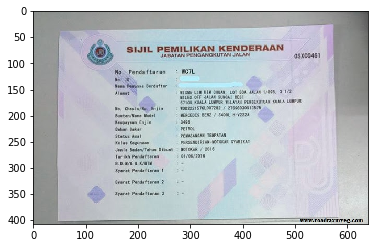

In [5]:
plt.imshow(ori_img)

In [6]:
# cv2.imshow('geran',img)
# cv2.imshow('geran gray',gray)
# cv2.imshow('negative', 255-gray)


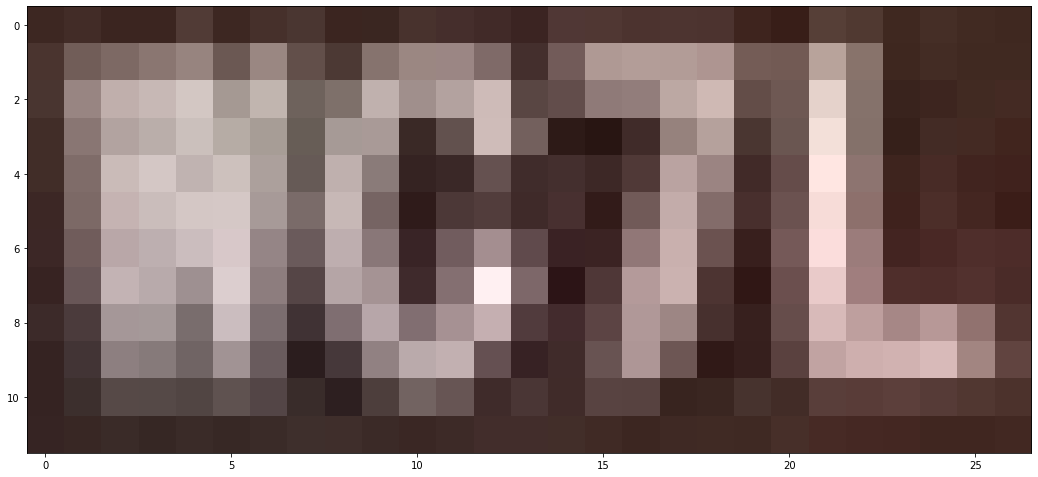

In [7]:
plt.figure(figsize=(18,20))
plt.imshow( 255-img)

In [53]:
ret, thresh = cv2.threshold(gray, 127,255,cv2.THRESH_BINARY_INV)

showImg(thresh)

In [50]:
adaptive_threshold = cv2.adaptiveThreshold(thresh, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                           cv2.THRESH_BINARY, 11, 10)
# showImg(adaptive_threshold)

In [73]:
def cropImg(mask, img):
    # Now crop
    (y, x) = np.where(mask == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    img = img[topy:bottomy+1, topx:bottomx+1]
    return img

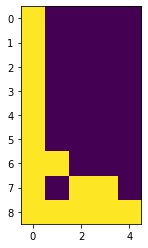

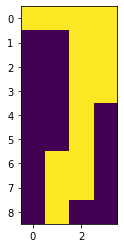

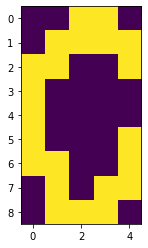

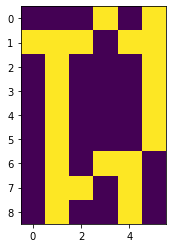

In [76]:
contours, hierarchy = cv2.findContours(adaptive_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i,cntr in enumerate(contours):
    canvas = np.zeros(thresh.shape, dtype="uint8")
    mask = cv2.drawContours(canvas, contours, i, (255,255,255), 1)
    
    plt.figure()
    plt.imshow(cropImg(mask, canvas))
#     plt.imshow(mask)
plt.show()

In [52]:
len(contours)

4

In [151]:
hierarchy

array([[[-1, -1, -1, -1]]], dtype=int32)